# Multiperiod Reports by Year in Beancount
If you've ever used [hledger](https://hledger.org/), you might like its ability to produce nice reports. One of the reports' feature is the table structure, where rows are accounts and columns are weeks, months, quarters or years. Looking at earnings and spendings as a function of time can give you more insights about your finances.

However, if you are using [beancount](http://furius.ca/beancount/), this feature is not yet supported in the command line interface. You need to use [fava](https://github.com/beancount/fava), an awesome web-interface for beancount, which has a graph drawing capability as described in this tutorial. fava is not ideal and sometimes you might need more custom reports than the ones available in fava.

This notebook provides methodology and tools to:
- Process BQL query's output using Pandas library
- Generate yearly totals (multiperiod reports by year) by pivoting a table
- Aggregate values at different account levels for the provided account hierarchy
- Draw treemap plots of expenses for all time period

Details are in [this blog post](https://www.isabekov.pro/multiperiod-hledger-style-reports-in-beancount-pivoting-a-table/).

In [1]:
from beancount.loader import load_file
from beancount.query.query import run_query
from beancount.query.numberify import numberify_results
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_column', 15)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 50000)
pd.set_option('display.width', 5000000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('precision', 2)
pd.set_option('expand_frame_repr', True)
import squarify
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (15, 5)

## Create and Load an Example Beancount Journal File

In [2]:
FileName = "example.beancount"
if not os.path.isfile(FileName):
    os.system("bean-example > {}".format(FileName))      
    
entries, _, opts = load_file(FileName)
currency = opts["operating_currency"][0]
# Main currency
currency

'USD'

## Investigating a Transaction

In [3]:
# Not all of the entries are transactions
len(entries)

2245

In [4]:
type(entries[-1])

beancount.core.data.Transaction

In [5]:
entries[-1].postings[0].account

'Assets:US:BofA:Checking'

In [6]:
entries[-1].postings[0].units

2832.14 USD

In [7]:
entries[-1].payee

'Hoogle'

In [8]:
entries[-1].narration

'Payroll'

## Executing a BQL Query

In [9]:
cols, rows = run_query(entries, opts, 
                       "SELECT   account,   YEAR(date) AS year,   SUM(convert(position, '{}', date)) AS amount\
                        WHERE    account ~ 'Expenses'\
                        OR       account ~ 'Income'\
                        GROUP BY account, year ORDER BY account, year".format(currency)
                      )
cols

[('account', str),
 ('year', int),
 ('amount', beancount.core.inventory.Inventory)]

In [10]:
rows[:3]

[ResultRow(account='Expenses:Financial:Commissions', year=2018, amount=(116.35 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2019, amount=(125.30 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2020, amount=(232.70 USD))]

In [11]:
cols, rows = numberify_results(cols, rows)
cols

[('account', str),
 ('year', int),
 ('amount (USD)', decimal.Decimal),
 ('amount (VACHR)', decimal.Decimal),
 ('amount (IRAUSD)', decimal.Decimal)]

In [12]:
rows[:3]

[['Expenses:Financial:Commissions', 2018, Decimal('116.35'), None, None],
 ['Expenses:Financial:Commissions', 2019, Decimal('125.30'), None, None],
 ['Expenses:Financial:Commissions', 2020, Decimal('232.70'), None, None]]

## Converting Result Rows to a Pandas Dataframe

In [13]:
df = pd.DataFrame(rows, columns=[k[0] for k in cols])
df.head()

,account,year,amount (USD),amount (VACHR),amount (IRAUSD)
0,Expenses:Financial:Commissions,2018,116.35,None,None
1,Expenses:Financial:Commissions,2019,125.30,None,None
2,Expenses:Financial:Commissions,2020,232.70,None,None
3,Expenses:Financial:Fees,2018,48.00,None,None
4,Expenses:Financial:Fees,2019,48.00,None,None


In [14]:
df.rename(columns={"account": "Account", "year":"Year", "amount ({})".format(currency): "Amount ({})".format(currency)}, inplace=True)
df.dtypes

Account            object
Year                int64
Amount (USD)       object
amount (VACHR)     object
amount (IRAUSD)    object
dtype: object

In [15]:
df = df.astype({"Account": str, "Year": int, "Amount ({})".format(currency): np.float})
df = df[["Account", "Year", "Amount ({})".format(currency)]].fillna(0)
df.head()

,Account,Year,Amount (USD)
0,Expenses:Financial:Commissions,2018,116.35
1,Expenses:Financial:Commissions,2019,125.30
2,Expenses:Financial:Commissions,2020,232.70
3,Expenses:Financial:Fees,2018,48.00
4,Expenses:Financial:Fees,2019,48.00


## Pivoting a Table by Year

In [16]:
df = df.pivot_table(index="Account", columns=['Year']).fillna(0).reset_index()
df.head()

Account Amount (USD)                  
Year                                         2018     2019     2020
0     Expenses:Financial:Commissions       116.35   125.30   232.70
1            Expenses:Financial:Fees        48.00    48.00    48.00
2               Expenses:Food:Coffee         5.49    36.76    43.07
3            Expenses:Food:Groceries      2298.84  2365.05  2291.58
4           Expenses:Food:Restaurant      4064.22  4955.84  4401.07

## Creating Multi-Level Accounts

In [17]:
n_levels = df["Account"].str.count(":").max() + 1
n_levels

6

In [18]:
cols = ["Account_L{}".format(k) for k in range(n_levels)]
cols

['Account_L0',
 'Account_L1',
 'Account_L2',
 'Account_L3',
 'Account_L4',
 'Account_L5']

In [19]:
df[cols] = df["Account"].str.split(':', n_levels - 1, expand=True)
df = df.fillna('').drop(columns="Account", level=0).set_index(cols)
df.head()

Amount (USD)                  
Year                                                                       2018     2019     2020
Account_L0 Account_L1 Account_L2  Account_L3 Account_L4 Account_L5                               
Expenses   Financial  Commissions                                        116.35   125.30   232.70
                      Fees                                                48.00    48.00    48.00
           Food       Coffee                                               5.49    36.76    43.07
                      Groceries                                         2298.84  2365.05  2291.58
                      Restaurant                                        4064.22  4955.84  4401.07

## Aggregation at Different Account Levels

In [20]:
df_L1 = df.groupby(["Account_L0", "Account_L1"]).sum()
df_L1.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [21]:
df_L0 = df.groupby(["Account_L0"]).sum()
df_L0.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [22]:
# Net income
-df_L0.sum(axis=0).to_frame().rename(columns={0: "Net income"}).transpose()

Amount (USD)                    
Year               2018      2019      2020
Net income     36820.29  35203.21  42039.67

In [23]:
# Invert the sign of the "Income" account. Negative income is counter-intuitive.
df_L0.loc["Income"] = -df_L0.loc["Income"]
df_L0 = df_L0.transpose().reset_index()
df_L0

Account_L0,level_0,Year,Expenses,Income
0,Amount (USD),2018,93179.69,129999.98
1,Amount (USD),2019,95025.63,130228.84
2,Amount (USD),2020,93891.22,135930.89


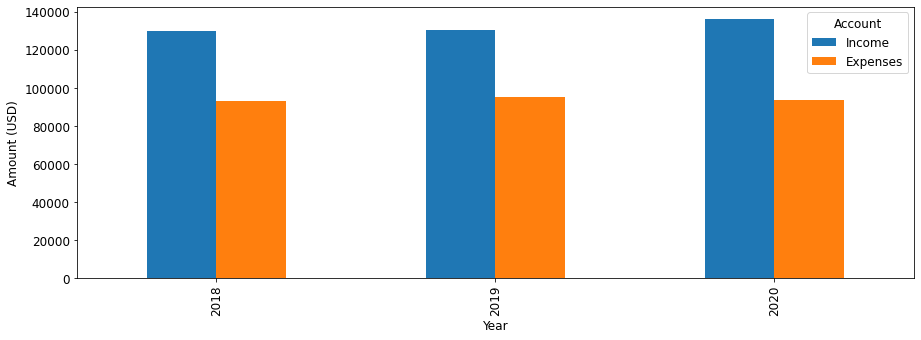

In [24]:
df_L0.columns.name = "Account"
df_L0.plot.bar(x="Year", y=["Income", "Expenses"], xlabel="Year", ylabel=df_L0["level_0"][0], rot=90)
plt.show()

## Treemap Plot of Expenses

In [25]:
tot = df_L1.sum(axis=1).to_frame().sort_values(by=0, ascending=False)
tot

0
Account_L0 Account_L1           
Expenses   Taxes       157987.98
           Home         91173.19
           Food         20461.92
           Health        7655.10
           Transport     4200.00
           Financial      618.35
           Vacation         0.00
Income     US         -396159.71

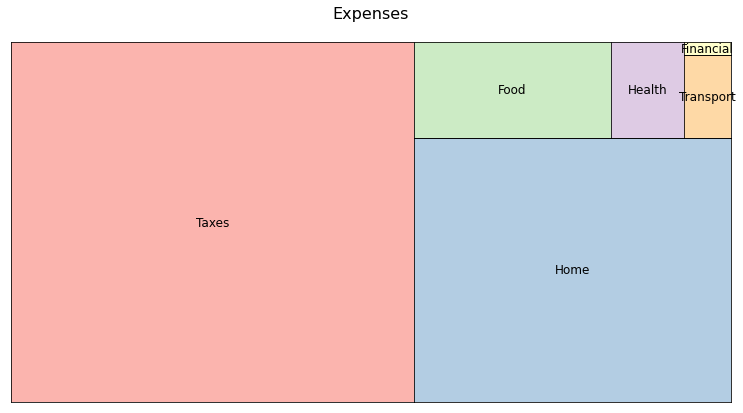

In [26]:
data = tot.loc["Expenses"].sort_values(by=0, ascending=False)
idx = [k[0] != 0 for k in data.values]
values = data.values[idx]
labels = data.index[idx]

width = 1
height = 0.5
values_norm = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(values_norm, 0, 0, width, height)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Expenses', x=0.5, y=0.55, fontsize=16)
axes = [fig.add_axes([rect['x'], rect['y'], rect['dx'], rect['dy'], ]) for rect in rects]

for ax, txt, color in zip(axes, labels, plt.cm.Pastel1.colors):
    ax.text(0.5, 0.5, txt, horizontalalignment='center', verticalalignment='center')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor(color)    
plt.show()